### Imports

In [14]:
import pandas as pd
import datetime
import os
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.errors import SettingWithCopyWarning


warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

### Parameters

In [15]:
buy_threshold = 0
sell_threshold = 9
starting_balance = 100000

run_optimizing = False
google_colab = False

### Data loading

In [16]:
if google_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1-kLmDPAmiTHNw_cv3lr6wY9DfSt8RSHv"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('05-07_11-26.csv')  
    df = pd.read_csv('05-07_11-26.csv')
else:
    # Set the path to the root directory
    path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
    # Read dataframes using Dask
    df = pd.read_csv(path + '/data/predictions/13_2.csv')

### Data processing

In [17]:
# Dates
df['Expiry_date'] = pd.to_datetime(df['Quote_date']) + pd.to_timedelta(df['TTM'], unit='D')
df['Quote_date'] = pd.to_datetime(df['Quote_date'])
df['Expiry_date'] = pd.to_datetime(df['Expiry_date'])

# Adding option ID
df["Option_ID"] = df["Expiry_date"].astype(str) + "-" + df["Strike"].astype(str)

# Dataframe for underlying matching in TTM = 0 rows
df_original = df[(df["Quote_date"] >= "2018-01-01") & (df["Quote_date"] <= "2019-01-01")]

# Period to be traded on
df = df[(df["Expiry_date"] >= "2018-01-01") & (df["Expiry_date"] <= "2018-01-29")]
df = df[(df["Quote_date"] >= "2018-01-01") & (df["Quote_date"] <= "2018-01-29")]

Adding TTM=0 row

In [18]:
# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

groups = df.groupby(['Expiry_date', 'Strike'])

for _, group in groups:

    # Sort group so that the last row is the one with the lowest TTM
    group = group.sort_values('TTM', ascending=False)

    # Taking row from option group (could be any) to be used in getting the Strike price
    last_row = group.iloc[-1]
    
    expiry_date = last_row['Expiry_date']

    # Get the underlying price on the day of expiry
    underlying_last_on_expiry = df_original.loc[df_original['Quote_date'] == expiry_date, 'Underlying_last'].iloc[0]
    # Calculate the intrinsic value
    intrinsic_value = np.maximum(underlying_last_on_expiry - last_row['Strike'], 0)

    new_row = last_row.copy()
    new_row['Quote_date'] = expiry_date
    new_row['Expiry_date'] = expiry_date
    new_row['TTM'] = 0
    new_row['Underlying_last'] = underlying_last_on_expiry
    new_row['Price'] = intrinsic_value

    df = df.append(new_row, ignore_index=True)

# Sort the dataframe by Quote_date and Expiry_date
df = df.sort_values(['Quote_date', 'Expiry_date'])

/var/folders/wk/x86_p6511l95p594k6qnb98h0000gn/T/ipykernel_73552/2939185186.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


### Functions

In [19]:
def generate_buy_sell_signals(df, buy_threshold, sell_threshold):
    buy_signal = (df['Prediction'] / df['Price']) >= buy_threshold
    sell_signal = (df['Price'] / df['Prediction']) >= sell_threshold
    return buy_signal, sell_signal


def trader(df, buy_signal, sell_signal, starting_balance, price_cap_lower, ttm_cap_lower):
    df = df.copy()
    # Filter out options that expire before the last quote date
    last_date = df['Quote_date'].max()
    df = df[df['Expiry_date'] <= last_date]

    df = df[df["TTM"] >= ttm_cap_lower]
    
    df['Signal'] = 0
    df.loc[buy_signal, 'Signal'] = 1
    df.loc[sell_signal, 'Signal'] = -1
    df['Position_this_opt'] = 0
    df['Balance'] = starting_balance  # Initialize Balance column with starting_balance
    df['Profit'] = 0

    quote_date_grouped = df.groupby('Quote_date')

    balance = starting_balance

    for quote_date, group in quote_date_grouped:
        group = group.sample(frac=1)

        for _, row in group.iterrows():
            # Don't consider options with a price lower than 3
            if row['Price'] < price_cap_lower:
                continue

            option_position = df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] <= row['Quote_date']), 'Position_this_opt'].iloc[-1]

            # Buy the option
            if row['Signal'] == 1 and balance >= row['Price'] and row["Quote_date"] != row["Expiry_date"]:
                balance -= row['Price']
                option_position += 1
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # Sell the option
            elif row['Signal'] == -1 and row["Quote_date"] != row["Expiry_date"] and balance > 0:
                balance += row['Price']
                option_position -= 1
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            # Option expires
            elif row["Quote_date"] == row["Expiry_date"] and option_position != 0:
                intrinsic_value = max(0, row['Underlying_last'] - row['Strike'])
                adjustment = intrinsic_value if option_position >= 1 else -intrinsic_value
                balance += adjustment * abs(option_position)
                option_position = 0
                # Directly update values in the original dataframe
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Position_this_opt'] = option_position
                df.loc[(df['Option_ID'] == row['Option_ID']) & (df['Quote_date'] == row['Quote_date']), 'Balance'] = balance

            df.loc[(df['Quote_date'] == quote_date) & (df['Position_this_opt'] == 0), 'Balance'] = balance
        
        # Print date and balance if quote_date is 1. january, 1. april, 1. july or 1. october
        if quote_date.day == 1 or quote_date.day == 15:
            print("On, {}, the balance is: {}".format(quote_date, balance))
    return df


def calculate_options_value(df):
    df['Options_value'] = 0
    # Iterate over every Quote_date
    for date in df['Quote_date'].unique():
        # For every Quote date, multiply each row's Position_this_opt with the Price and sum it up.
        options_value_sum = (df.loc[df['Quote_date'] == date, 'Position_this_opt'] * df.loc[df['Quote_date'] == date, 'Price']).sum()
        # The result should be added to every row with the same Quote_date in the Options_value
        df.loc[df['Quote_date'] == date, 'Options_value'] = options_value_sum
    df['Total_value'] = df['Balance'] + df['Options_value']
    return df

### Run code

In [20]:
def print_results(df, starting_balance):
    print("Starting balance", starting_balance)
    print("Ending balance", df['Balance'].iloc[-1])
    print("Number of trades", df['Signal'].abs().sum())
    profit = df['Balance'].iloc[-1] - starting_balance
    print("Profit", profit)
    print("Profit per trade", profit / df['Signal'].abs().sum())
    print("Profit per day", profit / (df['Quote_date'].max() - df['Quote_date'].min()).days)
    num_days = (df['Quote_date'].max() - df['Quote_date'].min()).days
    print("Number of days", num_days)
    print("Sharpe ratio: ", sharpe_ratio(df))

In [21]:
def sharpe_ratio(df):
    df = df.copy()
    # Group by Quote_date and keep the last row of each group
    df = df.groupby('Quote_date').last()
    # Calculate daily returns
    df['Daily_Returns'] = df['Total_value'].pct_change()
    # Convert the annual risk-free rate to a daily rate
    df['Daily_Rf'] = (1 + df['R'])**(1/252) - 1
    # Calculate the excess returns
    excess_returns = df['Daily_Returns'] - df['Daily_Rf']
    # Calculate sharpe ratio
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())
    return sharpe_ratio

In [22]:
if run_optimizing == False:
    df = df.copy()
    buy_signal, sell_signal = generate_buy_sell_signals(df, buy_threshold, sell_threshold)
    df = trader(df, buy_signal, sell_signal, starting_balance)
    df = calculate_options_value(df)
    print_results(df, starting_balance)

Starting balance 100000
Ending balance 210792.88499999966
Number of trades 7808
Profit 110792.88499999966
Profit per trade 14.189662525614711
Profit per day 4103.440185185173
Number of days 27
Sharpe ratio:  4.906590325730092


### Analysis

In [23]:
def plot(df):
    # Just keep one row per Quote_date, and that should be the last row
    df = df.groupby('Quote_date').last()
    plt.plot(df['Total_value'], label='Total value')
    plt.plot(df['Balance'], label='Balance')
    plt.plot(df['Options_value'], label='Options value')
    plt.title('Portfolio value over time')
    # Make plot smaller
    ax = plt.gca()
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

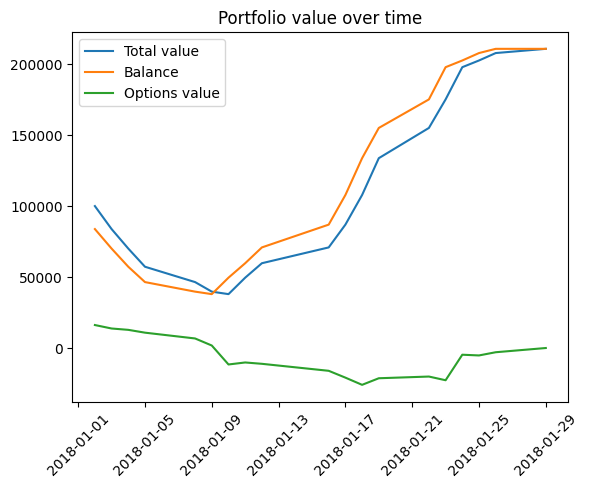

In [24]:
if run_optimizing == False:
    plot(df)

### Finding best thresholds

In [25]:
if run_optimizing:
    # Initialize wandb
    !pip install wandb
    import wandb
    wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")

    # Define the hyperparameters
    sweep_config = {
    'method': 'grid',
    'name': 'Small dataset - New sharpe ratio',
    'metric': {
        'goal': 'maximize', 
        'name': 'sharpe_ratio'
        },
    'parameters': {
        'buy_threshold': {
            'values': [0.1, 1, 4, 8, 12]},
        'sell_threshold': {
            'values': [0.1, 1, 4, 8, 12]},
        'starting_balance': {
            'values': [100000, 1000000]},
        'price_cap_lower': {
            'values': [0, 1, 3, 5]},
        'ttm_cap_lower': {
            'values': [0, 1, 3, 5]},
        }
    }
    sweep_id = wandb.sweep(sweep=sweep_config, project='options-trading') 


In [26]:
if run_optimizing:
    def find_best_thresholds():
        run = wandb.init(project = "options-trading")
        df = df_read.copy()
        buy_signal, sell_signal = generate_buy_sell_signals(df, run.config.buy_threshold, run.config.sell_threshold)
        df = trader(df, buy_signal, sell_signal, run.config.starting_balance, price_cap_lower = run.config.price_cap_lower, ttm_cap_lower = run.config.ttm_cap_lower)
        df = calculate_options_value(df)
        run.log({"buy_threshold": run.config.buy_threshold, "sell_threshold": run.config.sell_threshold, "sharpe_ratio": sharpe_ratio(df)})
        # Wandb callback
        print("buy_threshold", run.config.buy_threshold)
        print("sell_threshold", run.config.sell_threshold)
        print("starting_balance", run.config.starting_balance)
        print("Ending balance", df['Balance'].iloc[-1])
        print("Number of trades", df['Signal'].abs().sum())
        print("sharpe_ratio", sharpe_ratio(df))
        plot(df)
        run.finish()

    wandb.agent(sweep_id=sweep_id, function=find_best_thresholds, project='options-trading', count = 1000)